# Tiltmeter Demo
A demonstration of the basic tiltmeter concepts. For queries, contact aph@sarao.ac.za.


                                                     Last updated 18/08/2025

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np

import dvs; from analysis import katselib, katseops, katsepnt
katselib.initsensorcache() # Speeds up repeated use of katselib.getsensorvalues()

/home/aph/work/dvs/libraries/analysis/katsemodels.py:1212: RuntimeWarning: divide by zero encountered in divide
  I_therm = lambda p, f_MHz: p[0] * (f_MHz/p[1])**2 * (1 - np.exp(-(f_MHz/p[1])**-2)) # The radiation intensity of a nebula in thermal equilibruim... Opacity tau(f)=(f/p[1])^2 fits the data.
/home/aph/work/dvs/libraries/analysis/katsemodels.py:1212: RuntimeWarning: invalid value encountered in multiply
  I_therm = lambda p, f_MHz: p[0] * (f_MHz/p[1])**2 * (1 - np.exp(-(f_MHz/p[1])**-2)) # The radiation intensity of a nebula in thermal equilibruim... Opacity tau(f)=(f/p[1])^2 fits the data.


## Frameworks

In [2]:
katsepnt.get_tilt_data?
# Note: 'wind' is just '{ant}_enviro_mean_wind_speed'; 'winddir' is just 'anc_wind_direction'

Signature:
katsepnt.get_tilt_data(
    timestamps,
    ants,
    min_azrange=340,
    Npts=360,
    GT=0,
    modes=None,
)
Docstring:
Generates "datasets" for tilt calibration measurements that were conducted during the specified
time window. Measurements are identified as per `_find_azrate_intervals_()` and, unless overridden by `modes`:
    `ap_mode == rate` for MeerKAT Receptors, or `mode == SCAN` for SKA Dishes.

@param timestamps: either (Tstart,Tstop) or timestamps [UTC] for the window of time to search for measurements.
@param ants: list of antennas to get data for, either fully qualified names, or MeerKAT antenna numbers.
@param min_azrange: minimum range in azimuth [deg] to qualify as a valid dataset (default 340)
@param Npts: number of sample points per interval or None to avoid resampling (default 360)
@param GT: amount of "guard time" around antenna state transitions [sec] (default 0)
@param modes: {"m|s":(mode_key,mode_val)} to override the default demarcation of a calibr

In [3]:
def filter_ds(tilt_ds, time_start, time_end=np.inf):
    """ @param tilt_ds: tilt dataset like {receptor:data_dict}
        @param time_start, time_end: timestamps [Unix seconds]
        @return: subset of tilt_ds with min & max timestamps only inside specified time range """
    filtered = {}
    for ant,data in tilt_ds.items():
        TS = data['TS']
        indices = [i for i,t in enumerate(data['TS']) if (time_start<=np.min(t)) and (np.max(t)<=time_end)]
        if (len(indices) > 0):
            filtered[ant] = {k:np.take(v,indices,axis=0) for k,v in data.items()}
    return filtered

In [4]:
katsepnt.fit_tiltmeasurements?

Signature:
katsepnt.fit_tiltmeasurements(
    data,
    ant='',
    Az=None,
    w_key=None,
    w_sense='inverse',
    mask=None,
    mask_sun=False,
    mask_wind=99,
    mask_wind_dirdelta=360,
    activecal_x=None,
    activecal_y=None,
    recal=0,
    applycal_x=None,
    applycal_y=None,
    harmonics=True,
    summary_plot=False,
    dateformat=True,
    verbose=True,
    debug=False,
)
Docstring:
Regrid data and compare across different measurements for a specific antenna.
Note that the data and mask are assumed to have identical time order; the results returned here are ordered by timestamp!

@param data: {"TS":[[...scanlen]*N_measurements], # [sec]
              "az":..., "el":..., "tiltx":..., "tilty":..., "tiltT":..., w_key:...} # [deg],[deg],[arcsec],[arcsec],[degC],[?]
@param ant: an identifier string or 'm-number' for the dataset, for default TILT_ACTIVE_CAL if any and added to figure captions (default "")
@param Az: Azimuth to re-grid to [deg]. Can be any 360deg, but d

In [5]:
def modeltilt(az, el, ox,oy,AN,AW, A2=0,P2=0, doxdel=0):
    """ This is ALMOST the model used by katsepnt.fit_tiltmeasurements except that:
        1. temperature compensation is omitted, for clarity
        2. the signs of the coefficients are swapped as necessary to represent **measurements** not **corrections**
        3. new term 'doxdel' (default 0) is added as explained below in this notebook.
        
        @param az, el: array of angles [deg]
        @param ox,oy,AN0,AW0: first order model of the tiltmeter inside the pedestal [arcsec]
        @param A2,P2: second order coefficients for the azimuth axis [arcsec, deg] (default 0)
        @param doxdel: fractional change in ox relative to the value at 50degEl [fraction/degEl] (default 0)
        @return: (tiltx, tilty) model tilt [arcsec, arcsec] """
    # The new bit
    el = np.squeeze(np.reshape(el,(-1,1)))
    ox = ox + doxdel*(el-50)
    # The simplified old bit
    az_n = np.squeeze(np.reshape(az,(-1,1)))/360.
    x = abs(A2)*np.cos(2*np.pi*(2*az_n)-P2*np.pi/180) - ox - AN*np.cos(2*np.pi*az_n) + AW*np.sin(2*np.pi*az_n)
    y = abs(A2)*np.sin(2*np.pi*(2*az_n)-P2*np.pi/180) - oy - AN*np.sin(2*np.pi*az_n) - AW*np.cos(2*np.pi*az_n)
    return x, y

## Data from Tilt monitoring measurements
Controlled motion with fixed sequence, have to fit a model to get the residuals.

In [6]:
# Pick an antenna and time interval of interest
ant = "s0117"
TS = np.arange(np.datetime64("2025-08-05 06:14:00", 's').astype(float), np.datetime64("2025-08-05 07:15:00", 's').astype(float), 1) # 1 second intervals

az, el, tiltx, tilty = [katselib.getsensorvalues("%s_%s"%(ant,katsepnt._TILT_CORR_KEYS_(ant)[_]['key']), TS, interpolate='linear')[1] \
                        for _ in ['az','el','tiltx','tilty']] # deg, deg, arcsec, arcsec

In [7]:
# We could also just load from our monitoring database and pick one specific measurement)
tilt_ds = katseops.load_tilt_ds("../ska117/l1_data/pedestal-tilt-modKz-s0117.pkl.zip")
print(tilt_ds[ant].keys())

#TS, az, el, tiltx, tilty = [tilt_ds[ant][key][0] for key in ['TS', 'az', 'el', 'tiltx', 'tilty']]

dict_keys(['TS', 'az', 'el', 'tiltx', 'tilty', 'tiltT', 'wind', 'winddir', 'an0', 'aw0'])


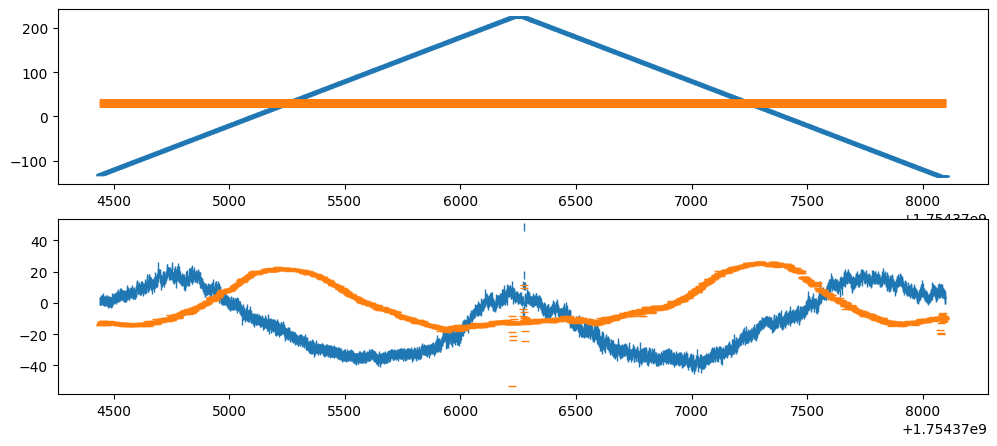

In [8]:
axs = plt.subplots(2,1, figsize=(12,5))[1]
axs[0].plot(TS, az, '_')
axs[0].plot(TS, el, '|')
axs[1].plot(TS, tiltx, '|')
axs[1].plot(TS, tilty, '_');

In [9]:
# Get the model coefficients for AN0 & AW0
tilt_ds = katseops.load_tilt_ds("../ska117/l1_data/pedestal-tilt-modKz-s0117.pkl.zip")

# We'll use the average of max ~2 hours around the time of interest because we know there are records around that time
tilt_ds = filter_ds(tilt_ds, np.mean(TS)-1*60*60, np.mean(TS)+1*60*60)

ox, oy, an0, aw0, a2, p2, *_ = katsepnt.fit_tiltmeasurements(tilt_ds[ant], ant, mask_wind=6, w_key='wind', verbose=True); plt.close('all')

s0117
  Tue Aug  5 06:28:34 2025 - Tue Aug  5 06:59:27 2025 UTC
  Temperatures 13.5 - 13.7 [degC], wind speed 2.9 - 5.1 [m/s]
  cal_x=[0, 4.84813681109536, 0, 0, 0, 15]
  cal_y=[0, 4.84813681109536, 0, 0, 0, 15]

Ensemble fit (weighting=inverse wind):
  ox=11.3228, oy=1.033; AN0=-6.56716, AW0=-20.2073 [arcsec]; A2=2.9 [arcsec] @ P2=-45[deg]
  ox=3.14521, oy=0.286945; AN0=-1.82421, AW0=-5.61315 (latest AN0=nan, AW0=nan) [millideg]

Individual measurements:
2025-08-05 06:28:34+00:00; +0.20deg/s; 2.9m/s;  11.236, 1.604;  -6.957, -20.033;	 2.8@-39;  resid=4.8,4.0;  (W=1.00)
2025-08-05 06:59:27+00:00; -0.20deg/s; 5.1m/s;  11.610, -0.860;  -5.275, -20.786;	 3.7@-59;  resid=4.6,4.2;  (W=0.30)

Residuals (individual pedestal models):
    X 1.3, Y 0.6, XY 0.7 [arcsec RMS]
    X 2.4, Y 1.1, XY 2.5 [arcsec 95pct radius]

Residuals (ensemble pedestal+bearing model):
    X 1.5, Y 1.7, XY 1.0 [arcsec RMS]
    X 2.7, Y 3.1, XY 3.6 [arcsec 95pct radius]


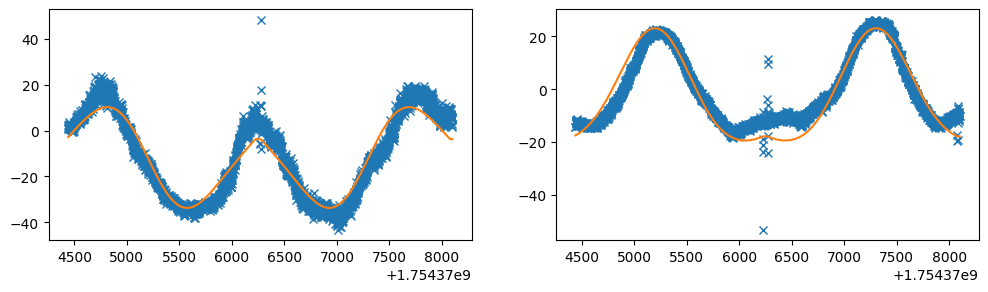

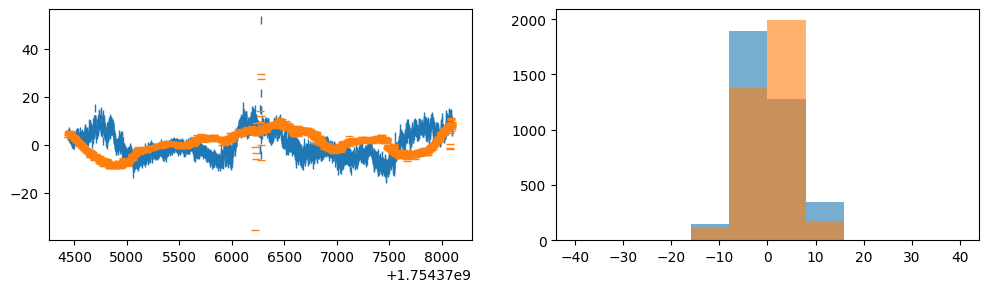

In [10]:
# Compare the measured tilt to the model tilt. Use [0] for ensamble mean or [-1] for latest
mx, my = modeltilt(az, el, ox[0], oy[0], an0[0], aw0[0], a2[0], p2[0]*180/np.pi)
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx, 'x')
axs[0].plot(TS, mx, '-')
axs[1].plot(TS, tilty, 'x')
axs[1].plot(TS, my, '-')

# These residuals should be zero mean, except for sun and wind influence
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx-mx, '|')
axs[0].plot(TS, tilty-my, '_')
axs[1].hist(tiltx-mx, range=(-40,40), alpha=0.6)
axs[1].hist(tilty-my, range=(-40,40), alpha=0.6);

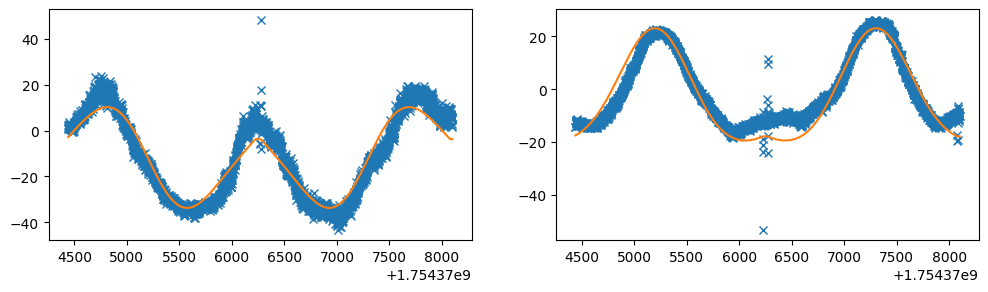

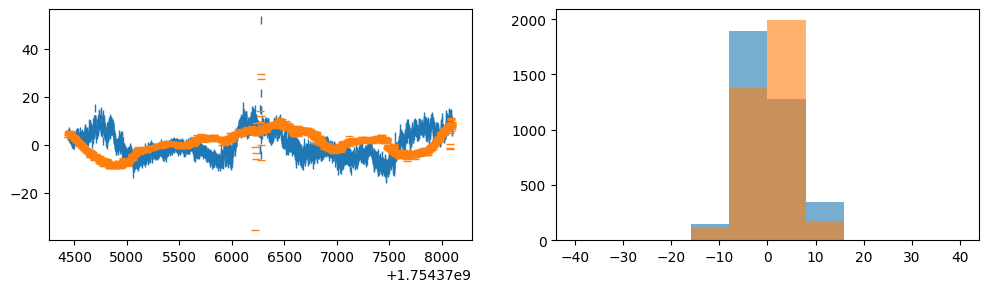

In [11]:
# Compare the measured tilt to the model tilt. Use [0] for ensamble mean or [-1] for latest
mx, my = modeltilt(az, el, ox[0], oy[0], an0[0], aw0[0], a2[0], p2[0]*180/np.pi)
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx, 'x')
axs[0].plot(TS, mx, '-')
axs[1].plot(TS, tilty, 'x')
axs[1].plot(TS, my, '-')

# These residuals should be zero mean, except for sun and wind influence
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx-mx, '|')
axs[0].plot(TS, tilty-my, '_')
axs[1].hist(tiltx-mx, range=(-40,40), alpha=0.6)
axs[1].hist(tilty-my, range=(-40,40), alpha=0.6);

# Data from normal operations
Have to remove the model tilt from the measured tilt to get residuals.

In [12]:
# We'll just use MKE117 for now, since we are "on top of" its tilt status
ant = "s0117"

# Get the tilt monitoring data (only the subset from when the ACU config was updated)
tilt_ds = katseops.load_tilt_ds("../ska117/l1_data/pedestal-tilt-modKz-s0117.pkl.zip")

## First Example

In [13]:
# Pick a time interval of interest
TS = np.arange(np.datetime64("2025-08-03 17:20", 's').astype(float), np.datetime64("2025-08-03 18:20", 's').astype(float), 1) # 1 second intervals

az, el, tiltx, tilty = [katselib.getsensorvalues("%s_%s"%(ant,katsepnt._TILT_CORR_KEYS_(ant)[_]['key']), TS, interpolate='linear')[1] \
                        for _ in ['az','el','tiltx','tilty']] # deg, deg, arcsec, arcsec

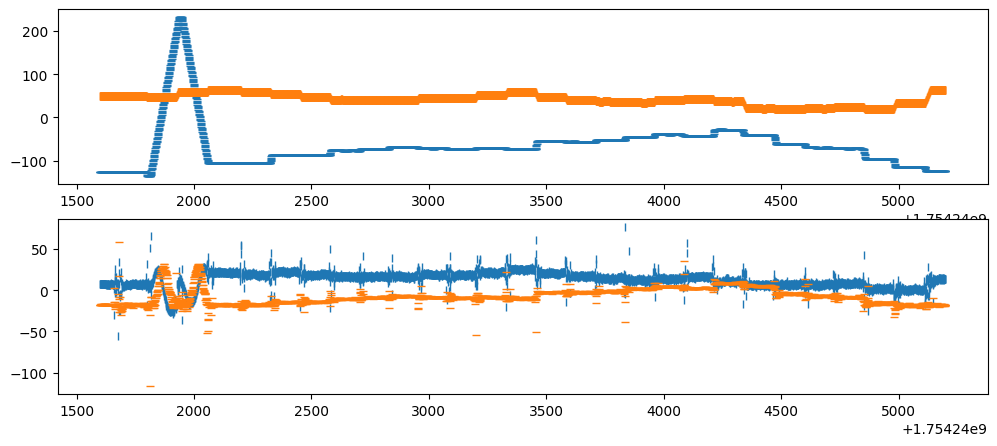

In [14]:
axs = plt.subplots(2,1, figsize=(12,5))[1]
axs[0].plot(TS, az, '_')
axs[0].plot(TS, el, '|')
axs[1].plot(TS, tiltx, '|')
axs[1].plot(TS, tilty, '_');

In [15]:
# Get the model coefficients for AN0 & AW0
# Only use the data of max ~2 days around the time of interest
sub_tilt_ds = filter_ds(tilt_ds, np.mean(TS)-2*24*60*60, np.mean(TS)+2*24*60*60)

# Tweak 'MASK' if necessary to get monitoring data that represents chosen time interval
#MASK = np.array([katselib.is_nighttime(t.min(), horizon=0) for t in sub_tilt_ds[ant]["TS"]])
MASK = np.array([np.min(el)<np.mean(e)<np.max(el) for e in sub_tilt_ds[ant]["el"]]) # Not typically necessary - we monitor at a fixed elevation of 50deg!

ox, oy, an0, aw0, a2, p2, *_ = katsepnt.fit_tiltmeasurements(sub_tilt_ds[ant], ant, mask=MASK, mask_wind=6, w_key='wind', verbose=True); plt.close('all')

s0117
  Tue Aug  5 06:28:34 2025 - Tue Aug  5 08:01:46 2025 UTC
  Temperatures 13.2 - 13.7 [degC], wind speed 2.9 - 5.1 [m/s]
  cal_x=[0, 4.84813681109536, 0, 0, 0, 15]
  cal_y=[0, 4.84813681109536, 0, 0, 0, 15]

Ensemble fit (weighting=inverse wind):
  ox=7.32481, oy=0.864307; AN0=-6.03165, AW0=-19.0137 [arcsec]; A2=3.7 [arcsec] @ P2=-43[deg]
  ox=2.03467, oy=0.240085; AN0=-1.67546, AW0=-5.2816 (latest AN0=nan, AW0=nan) [millideg]

Individual measurements:
2025-08-05 06:28:34+00:00; +0.20deg/s; 2.9m/s;  11.236, 1.604;  -6.957, -20.033;	 2.8@-39;  resid=4.8,4.0;  (W=1.00)
2025-08-05 06:59:27+00:00; -0.20deg/s; 5.1m/s;  11.610, -0.860;  -5.275, -20.786;	 3.7@-59;  resid=4.6,4.2;  (W=0.30)
2025-08-05 07:30:53+00:00; +0.20deg/s; 5.0m/s;  -0.467, 1.204;  -4.249, -18.591;	 4.2@-36;  resid=4.0,3.7;  (W=0.29)
2025-08-05 08:01:46+00:00; -0.20deg/s; 3.7m/s;  -0.126, 0.061;  -5.580, -15.390;	 5.6@-45;  resid=3.0,2.6;  (W=0.39)

Residuals (individual pedestal models):
    X 1.9, Y 1.4, XY 1.3 [ar

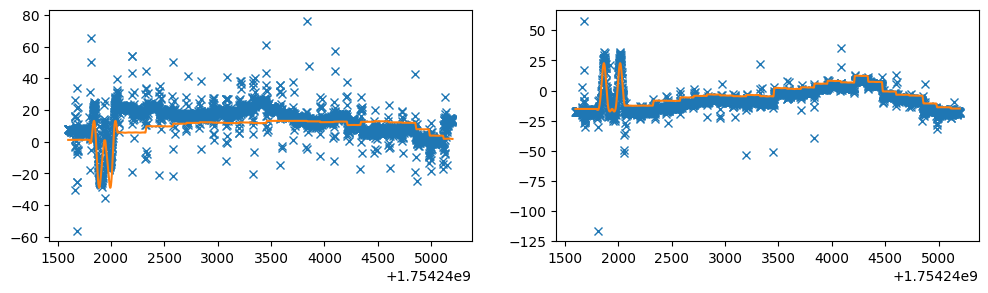

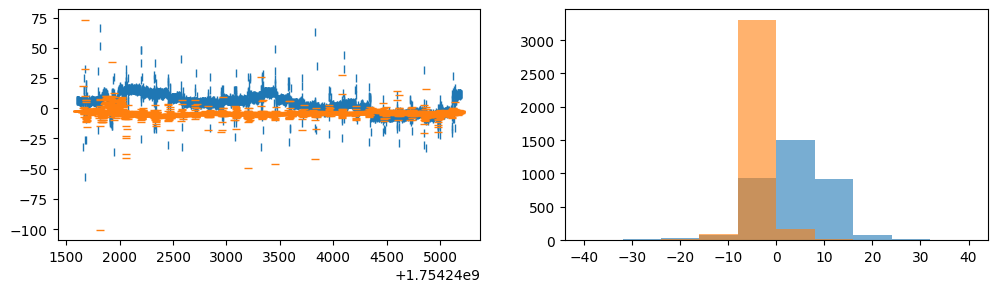

In [16]:
# Compare the measured tilt to the model tilt. Use [0] for ensamble mean or [-1] for latest
mx, my = modeltilt(az, el, ox[0], oy[0], an0[0], aw0[0], a2[0], p2[0]*180/np.pi)
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx, 'x')
axs[0].plot(TS, mx, '-')
axs[1].plot(TS, tilty, 'x')
axs[1].plot(TS, my, '-')

# These residuals should be zero mean, except for sun and wind influence
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx-mx, '|')
axs[0].plot(TS, tilty-my, '_')
axs[1].hist(tiltx-mx, range=(-40,40), alpha=0.6)
axs[1].hist(tilty-my, range=(-40,40), alpha=0.6);

In [17]:
# It's puzzling that tiltx doesn't match the model well - perhaps it's because we don't have tilt monitoring records
# representing these conditions (night time measurement, only have day time tilt monitoring with the latest calibration active)?

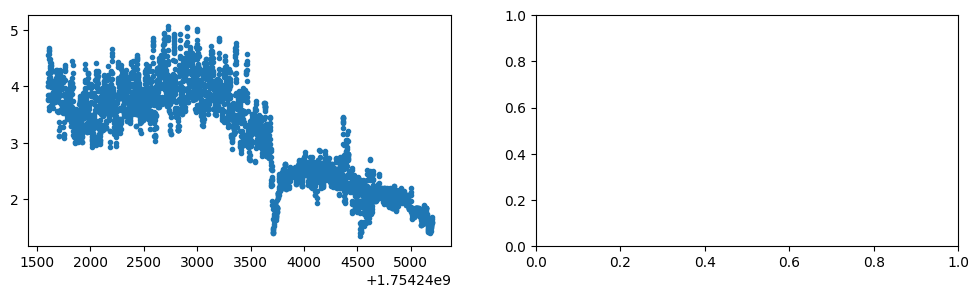

In [18]:
# What was the wind doing over this time interval?
wgust = katselib.getsensorvalues("anc_gust_wind_speed", TS, interpolate='linear')[1]
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, wgust, '.');

In [ ]:
# So the wind was < 5m/s, but note that on MeerKAT we see the impact on tilt at >3m/s so maybe the wind's paritally to blame?

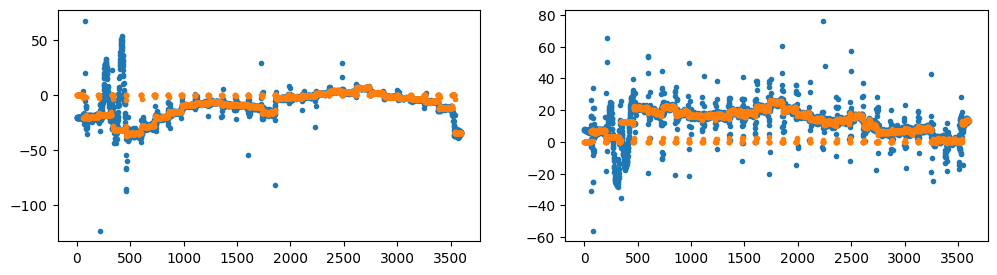

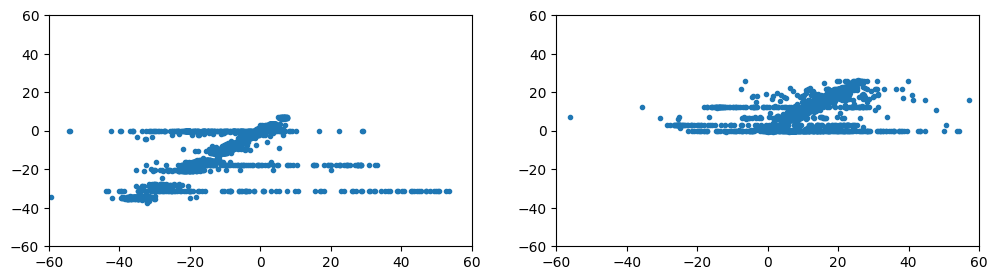

In [20]:
# These were the values applied by the ACU (note change of sign to match the same sense as katsepnt)
act_az_corr, act_el_corr = [-katselib.getsensorvalues("%s_%s"%(ant,_), TS, interpolate='linear')[1] \
                        for _ in ['dsm_azTiltCorr','dsm_elTiltCorr']] # arcsec

# Use the katsepnt model to calculate what the corrections should have been - from scratch!
az_corr, el_corr = katsepnt.get_tilt_corr(TS, ant, recalc=True) # arcsec

axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(az_corr, '.')
axs[0].plot(act_az_corr, '.')
axs[1].plot(el_corr, '.')
axs[1].plot(act_el_corr, '.')

axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(az_corr, act_az_corr, '.')
axs[1].plot(el_corr, act_el_corr, '.')
for ax in axs:
    ax.set_ylim(-60,60); ax.set_xlim(-60,60);

In [ ]:
# It seems that the MKE ACU implements the same model as used in katsepnt & MeerKAT ACUs

s0117
  Tue Aug  5 06:28:34 2025 - Tue Aug  5 09:04:01 2025 UTC
  Temperatures 13.2 - 13.7 [degC], wind speed 2.9 - 5.1 [m/s]
  cal_x=[0, 4.84813681109536, 0, 0, 0, 15]
  cal_y=[0, 4.84813681109536, 0, 0, 0, 15]

Ensemble fit (weighting=inverse wind):
  ox=-0.631107, oy=0.644415; AN0=-8.98776, AW0=-14.9193 [arcsec]; A2=3.2 [arcsec] @ P2=-37[deg]
  ox=-0.175307, oy=0.179004; AN0=-2.4966, AW0=-4.14425 (latest AN0=nan, AW0=nan) [millideg]

Individual measurements:
2025-08-05 06:28:34+00:00; +0.20deg/s; 2.9m/s;  11.236, 1.604;  -6.957, -20.033;	 2.8@-39;  resid=4.8,4.0;  (W=1.00)
2025-08-05 06:59:27+00:00; -0.20deg/s; 5.1m/s;  11.610, -0.860;  -5.275, -20.786;	 3.7@-59;  resid=4.6,4.2;  (W=0.30)
2025-08-05 07:30:53+00:00; +0.20deg/s; 5.0m/s;  -0.467, 1.204;  -4.249, -18.591;	 4.2@-36;  resid=4.0,3.7;  (W=0.29)
2025-08-05 08:01:46+00:00; -0.20deg/s; 3.7m/s;  -0.126, 0.061;  -5.580, -15.390;	 5.6@-45;  resid=3.0,2.6;  (W=0.39)
2025-08-05 08:33:14+00:00; +0.20deg/s; 2.9m/s;  -10.201, 1.163;  

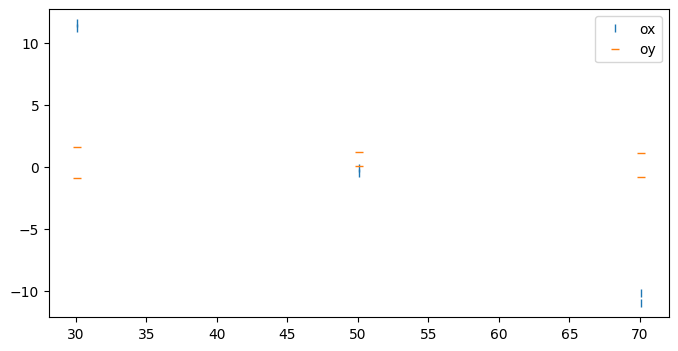

In [21]:
## Perhaps the issue with the model tiltx is that, due to unbalance, tiltx changes significantly over elevation?

# Here are three tilt measurements made at 30degEl, 50degEl, 70degEl (during day time, but focus on ox & oy!)
sub_tilt_ds = filter_ds(tilt_ds, np.datetime64("2025-08-05 05:00:00").astype(int), np.datetime64("2025-08-05 11:00:00").astype(int))
ox, oy, an0, aw0, a2, p2, *_ = katsepnt.fit_tiltmeasurements(sub_tilt_ds[ant], ant, mask_wind=6, w_key='wind', verbose=True); plt.close('all')
tilt_el = [np.mean(_) for _ in sub_tilt_ds[ant]['el']]
print("\nElevation angles:", tilt_el)

plt.figure(figsize=(8,4))
plt.plot(tilt_el, ox[1:], '|', label="ox") # [0] is the ensamble average
plt.plot(tilt_el, oy[1:], '_', label="oy")
plt.legend()

print("\ndox/del:")
print((np.diff(ox[1:])/np.diff(tilt_el))[np.abs(np.diff(tilt_el))>1], "arcsec/degEl")

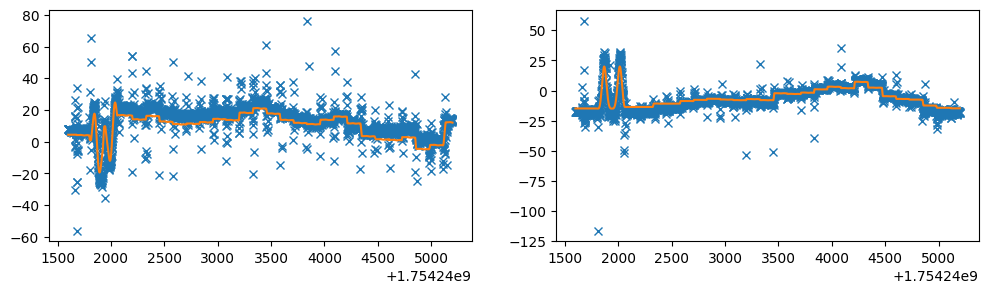

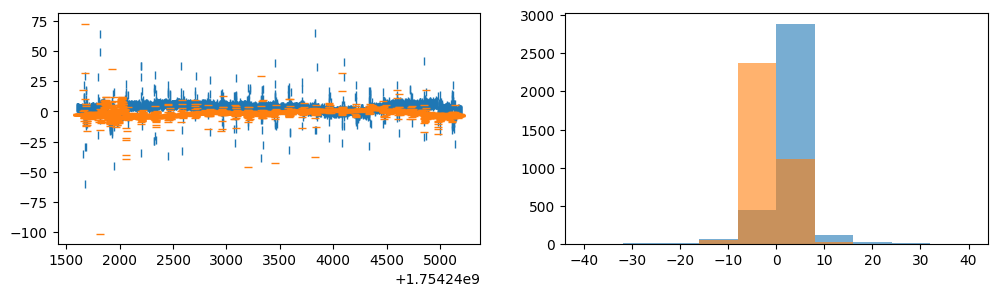

In [22]:
# So let's add the new term to the model:
# Compare the measured tilt to the model tilt. Use [0] for ensamble mean or [-1] for latest
mx, my = modeltilt(az, el, ox[0], oy[0], an0[0], aw0[0], a2[0], p2[0]*180/np.pi, -0.55) # <- new term
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx, 'x')
axs[0].plot(TS, mx, '-')
axs[1].plot(TS, tilty, 'x')
axs[1].plot(TS, my, '-')

# These residuals should be zero mean, except for sun and wind influence
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx-mx, '|')
axs[0].plot(TS, tilty-my, '_')
axs[1].hist(tiltx-mx, range=(-40,40), alpha=0.6)
axs[1].hist(tilty-my, range=(-40,40), alpha=0.6);

In [ ]:
# It looks like we've found it!

## Second Example

In [23]:
# Pick a time interval of interest
TS = np.arange(np.datetime64("2025-08-04 01:30", 's').astype(float), np.datetime64("2025-08-04 02:30", 's').astype(float), 1) # 1 second intervals

az, el, tiltx, tilty = [katselib.getsensorvalues("%s_%s"%(ant,katsepnt._TILT_CORR_KEYS_(ant)[_]['key']), TS, interpolate='linear')[1] \
                        for _ in ['az','el','tiltx','tilty']] # deg, deg, arcsec, arcsec

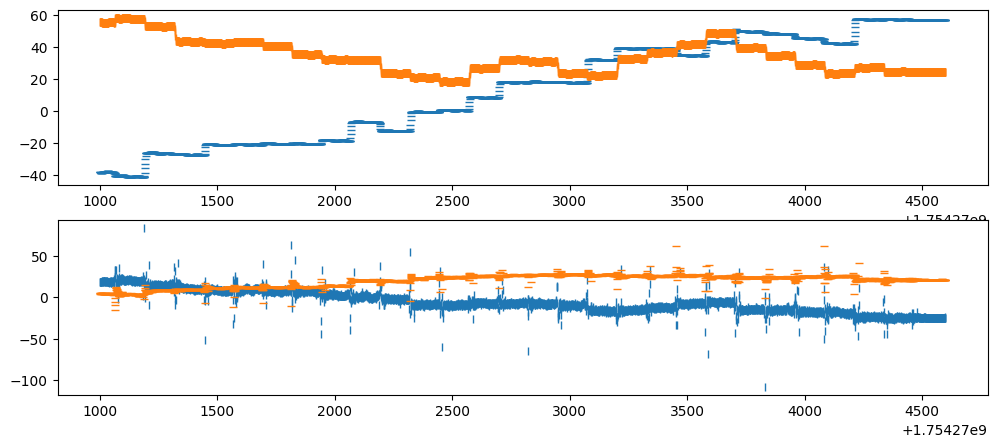

In [24]:
axs = plt.subplots(2,1, figsize=(12,5))[1]
axs[0].plot(TS, az, '_')
axs[0].plot(TS, el, '|')
axs[1].plot(TS, tiltx, '|')
axs[1].plot(TS, tilty, '_');

In [25]:
# Get the model coefficients for AN0 & AW0
# Only use the data of max ~2 days around the time of interest
sub_tilt_ds = filter_ds(tilt_ds, np.mean(TS)-2*24*60*60, np.mean(TS)+2*24*60*60)

# Tweak 'MASK' if necessary to get monitoring data that represents chosen time interval
#MASK = np.array([katselib.is_nighttime(t.min(), horizon=0) for t in sub_tilt_ds[ant]["TS"]])
MASK = np.array([np.min(el)<np.mean(e)<np.max(el) for e in sub_tilt_ds[ant]["el"]]) # Not typically necessary - we monitor at a fixed elevation of 50deg!

ox, oy, an0, aw0, a2, p2, *_ = katsepnt.fit_tiltmeasurements(sub_tilt_ds[ant], ant, mask=MASK, mask_wind=6, w_key='wind', verbose=True); plt.close('all')

s0117
  Tue Aug  5 06:28:34 2025 - Tue Aug  5 08:01:46 2025 UTC
  Temperatures 13.2 - 13.7 [degC], wind speed 2.9 - 5.1 [m/s]
  cal_x=[0, 4.84813681109536, 0, 0, 0, 15]
  cal_y=[0, 4.84813681109536, 0, 0, 0, 15]

Ensemble fit (weighting=inverse wind):
  ox=7.32481, oy=0.864307; AN0=-6.03165, AW0=-19.0137 [arcsec]; A2=3.7 [arcsec] @ P2=-43[deg]
  ox=2.03467, oy=0.240085; AN0=-1.67546, AW0=-5.2816 (latest AN0=nan, AW0=nan) [millideg]

Individual measurements:
2025-08-05 06:28:34+00:00; +0.20deg/s; 2.9m/s;  11.236, 1.604;  -6.957, -20.033;	 2.8@-39;  resid=4.8,4.0;  (W=1.00)
2025-08-05 06:59:27+00:00; -0.20deg/s; 5.1m/s;  11.610, -0.860;  -5.275, -20.786;	 3.7@-59;  resid=4.6,4.2;  (W=0.30)
2025-08-05 07:30:53+00:00; +0.20deg/s; 5.0m/s;  -0.467, 1.204;  -4.249, -18.591;	 4.2@-36;  resid=4.0,3.7;  (W=0.29)
2025-08-05 08:01:46+00:00; -0.20deg/s; 3.7m/s;  -0.126, 0.061;  -5.580, -15.390;	 5.6@-45;  resid=3.0,2.6;  (W=0.39)

Residuals (individual pedestal models):
    X 1.9, Y 1.4, XY 1.3 [ar

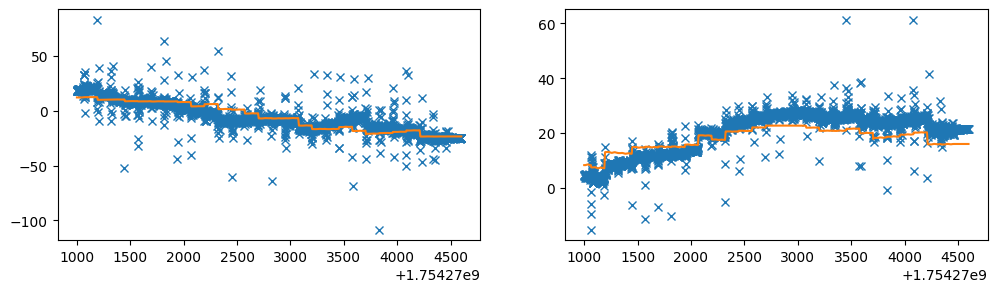

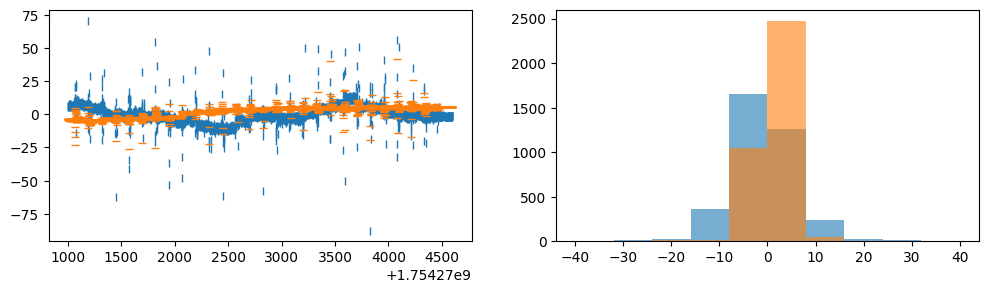

In [26]:
# Compare the measured tilt to the model tilt. Use [0] for ensamble mean or [-1] for latest
mx, my = modeltilt(az, el, ox[0], oy[0], an0[0], aw0[0], a2[0], p2[0]*180/np.pi)
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx, 'x')
axs[0].plot(TS, mx, '-')
axs[1].plot(TS, tilty, 'x')
axs[1].plot(TS, my, '-')

# These residuals should be zero mean, except for sun and wind influence
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx-mx, '|')
axs[0].plot(TS, tilty-my, '_')
axs[1].hist(tiltx-mx, range=(-40,40), alpha=0.6)
axs[1].hist(tilty-my, range=(-40,40), alpha=0.6);

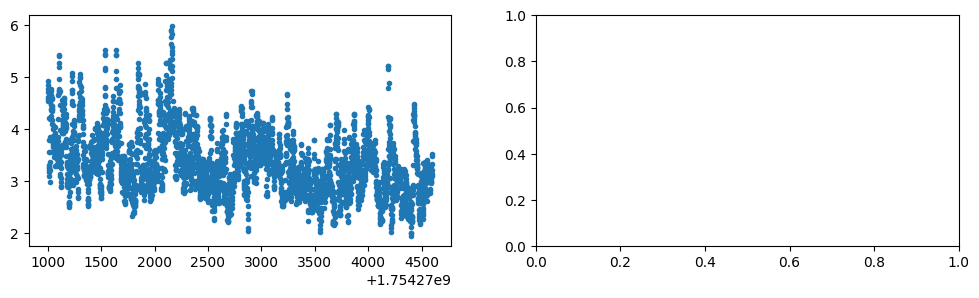

In [27]:
# What was the wind doing over this time interval?
wgust = katselib.getsensorvalues("anc_gust_wind_speed", TS, interpolate='linear')[1]
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, wgust, '.');

In [28]:
# Not really high, but again over 3.0m/s...

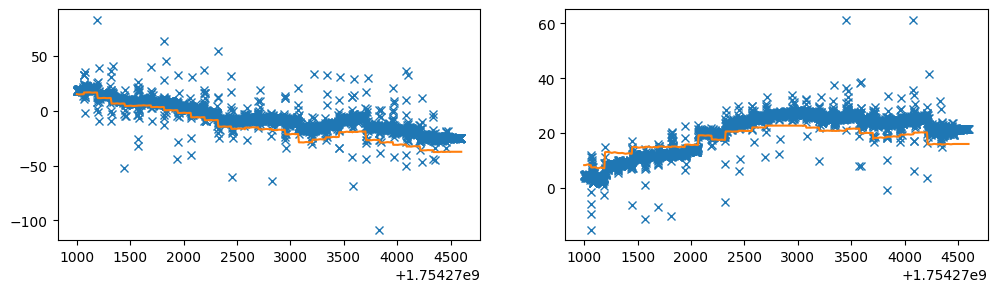

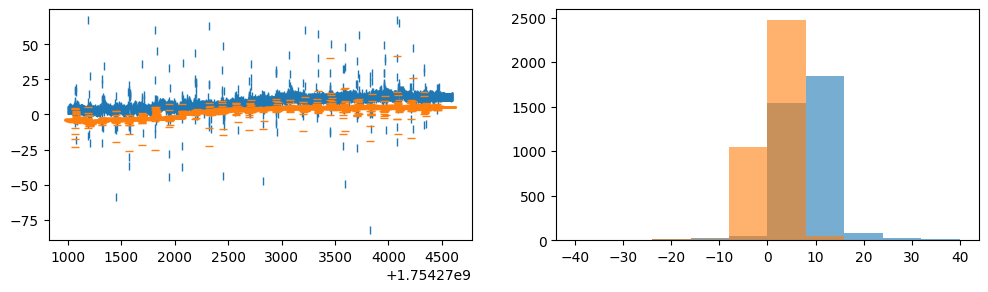

In [29]:
## Now let's add the new term to the model again
# Compare the measured tilt to the model tilt. Use [0] for ensamble mean or [-1] for latest
mx, my = modeltilt(az, el, ox[0], oy[0], an0[0], aw0[0], a2[0], p2[0]*180/np.pi, -0.55) # <- new term
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx, 'x')
axs[0].plot(TS, mx, '-')
axs[1].plot(TS, tilty, 'x')
axs[1].plot(TS, my, '-')

# These residuals should be zero mean, except for sun and wind influence
axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(TS, tiltx-mx, '|')
axs[0].plot(TS, tilty-my, '_')
axs[1].hist(tiltx-mx, range=(-40,40), alpha=0.6)
axs[1].hist(tilty-my, range=(-40,40), alpha=0.6);

In [ ]:
# This is more "well cosntrained" in ox, but now its clear both ox & oy drift over time. That's because
# we left out the tempertature compensation from this notebook's version of modeltilt() on purpose!

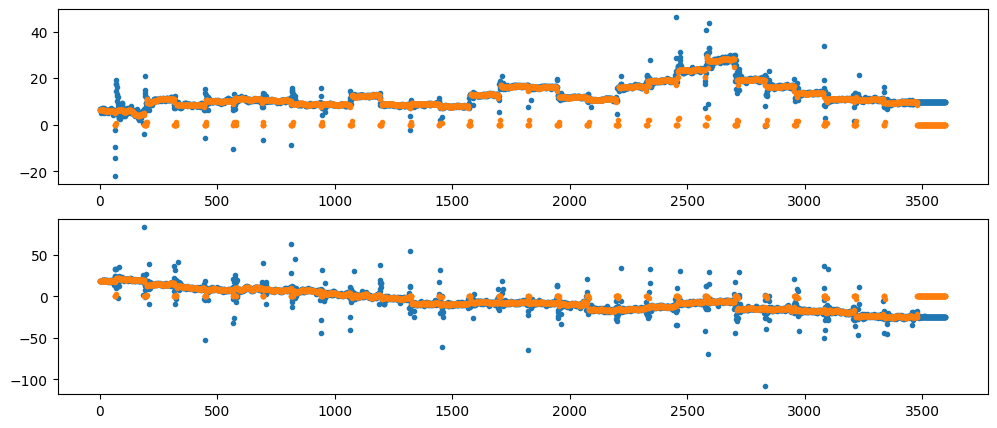

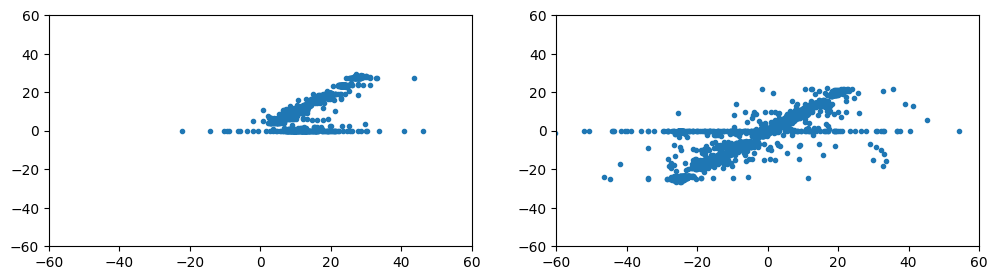

In [30]:
# These were the values applied by the ACU (need to change the sign to match the same sense as katsepnt)
act_az_corr, act_el_corr = [-katselib.getsensorvalues("%s_%s"%(ant,_), TS, interpolate='linear')[1] \
                        for _ in ['dsm_azTiltCorr','dsm_elTiltCorr']] # arcsec

# Use the katsepnt model to calculate what the corrections should have been - from scratch!
az_corr, el_corr = katsepnt.get_tilt_corr(TS, ant, recalc=True) # arcsec

axs = plt.subplots(2,1, figsize=(12,5))[1]
axs[0].plot(az_corr, '.')
axs[0].plot(act_az_corr, '.')
axs[1].plot(el_corr, '.')
axs[1].plot(act_el_corr, '.')

axs = plt.subplots(1,2, figsize=(12,3))[1]
axs[0].plot(az_corr, act_az_corr, '.')
axs[1].plot(el_corr, act_el_corr, '.')
for ax in axs:
    ax.set_ylim(-60,60); ax.set_xlim(-60,60);

In [ ]:
# Clearly the MKE ACU implements the same model as used in katsepnt & MeerKAT ACUs